# Week 4, Data Science in Neuroscience

## Plan for today

1. Detecting action potentials (spikes) from raw extracellular recordings and spike clustering
    * Filtering out unwanted frequencies from signals (1st session)
    * Detecting spike events in the filtered signals (2nd session)
    * Extracting spike waveforms from raw signals (2nd session)
    * Dimensionality reduction of spike waveforms (3rd session)
    * Clustering spike waveforms (4th session)

## A few words on week 5

Week 5 will be all about deep neural networks.

Things to do to get ready

* Install `pytorch` on your computer (https://pytorch.org/). Unless you have a Nvidia GPU, select cpu and not cuda.
* Get ready to run a jupyter notebook on Google colabs. We will use Google GPUs to train a model.
* Watch [MIT Introduction to Deep Learning](https://www.youtube.com/watch?v=QDX-1M5Nj7s&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI)

Our goals:

* Get familiar with building and training simple models with pytorch (Session 1)
* Use a deep neural network to classify images (Session 1)
* Use a deep neural network to track objects in images (Session 2)


***
## Extracting spike waveforms


### Let's get more data

For the next steps, we will need a longer recording duration so that we have more spikes to work with. We want to make sure that most neurons have the opportunity to fire a many spikes. This will make the clustering steps easier.

The file is in the `dataScienceNeuro/data/` folder.

https://github.com/kevin-allen/dataScienceNeuro/blob/main/data/longRaw.npy



You can load a new data file containing more samples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load the data
fs=20000
fileName = "../data/longRaw.npy" # binder users or people with a local git repository
dat = np.load(fileName)

## Exercise

Get familiar with you new array.

What can you tell me about this new NumPy array?

In [3]:
dat.shape, dat.dtype

((8, 1200000), dtype('int16'))

In [4]:
import spikeDetection

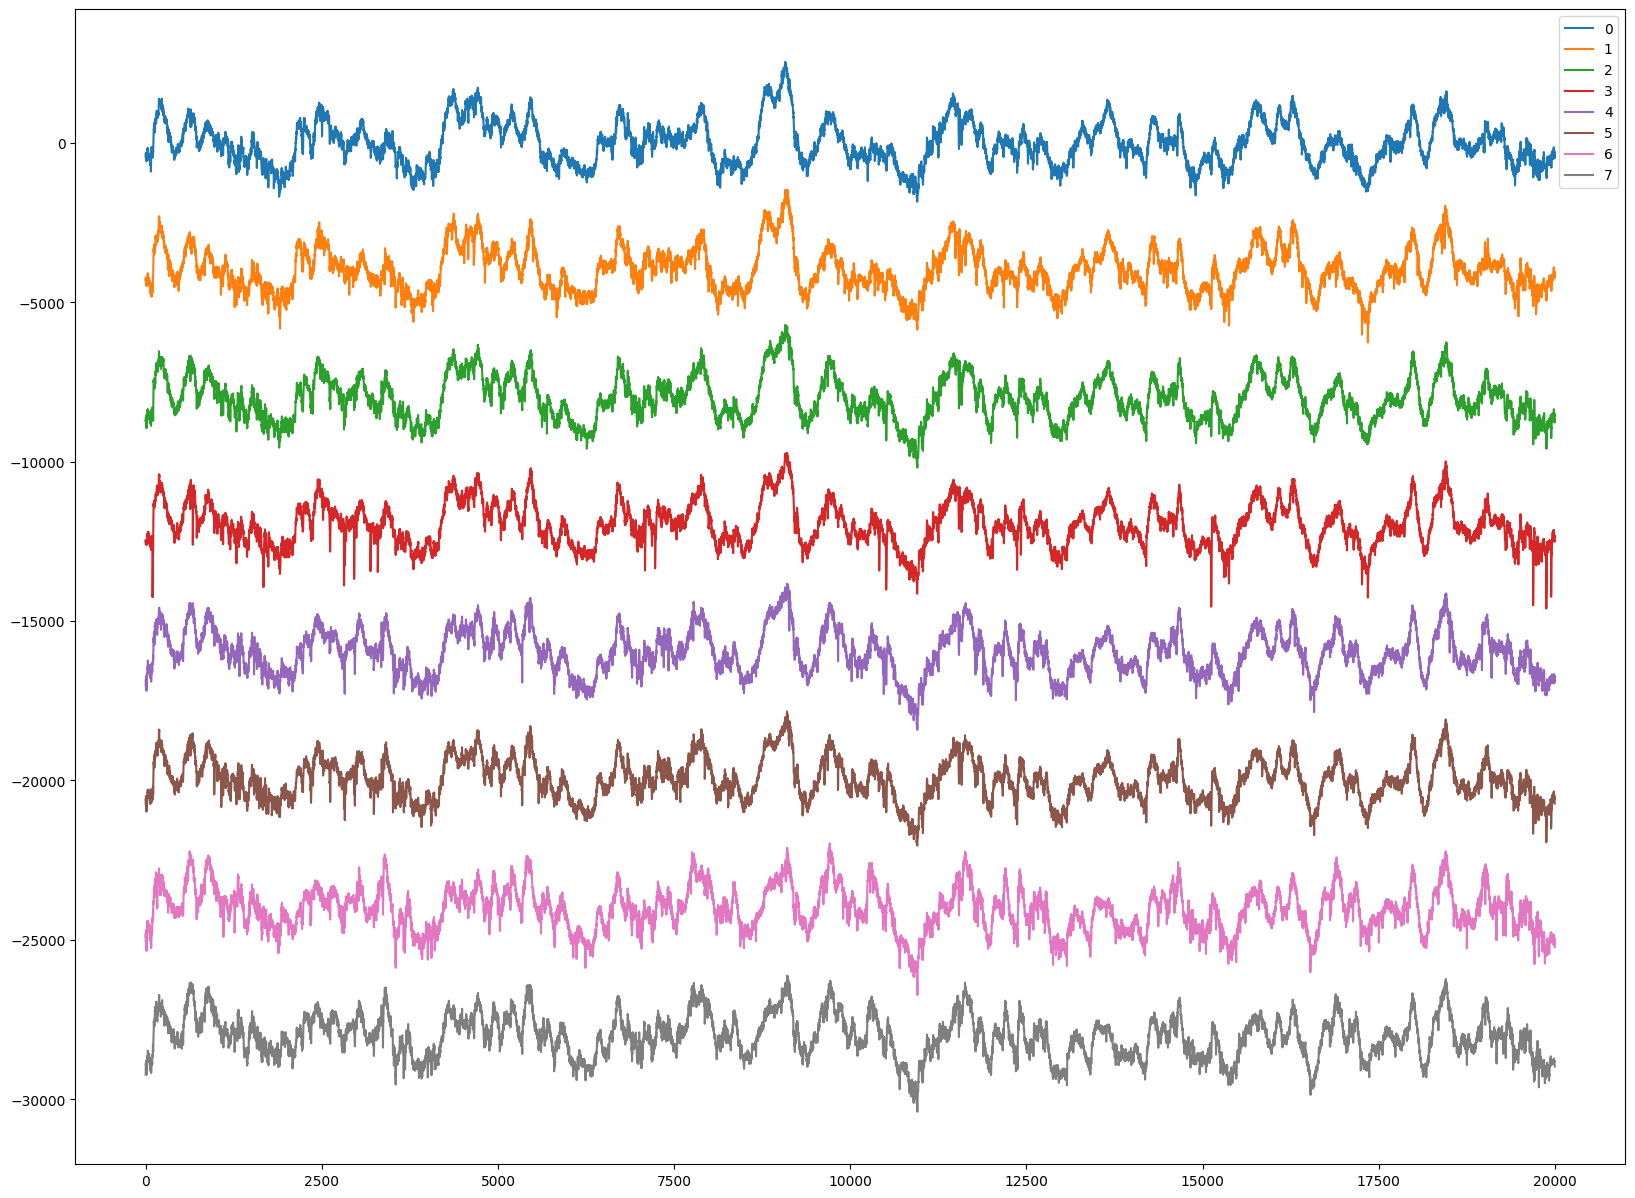

Detection chan 0, 123 spikes
Detection chan 1, 363 spikes
Detection chan 2, 134 spikes
Detection chan 3, 656 spikes
Detection chan 4, 612 spikes
Detection chan 5, 256 spikes
Detection chan 6, 224 spikes
Detection chan 7, 278 spikes
CPU times: user 591 ms, sys: 125 ms, total: 716 ms
Wall time: 726 ms


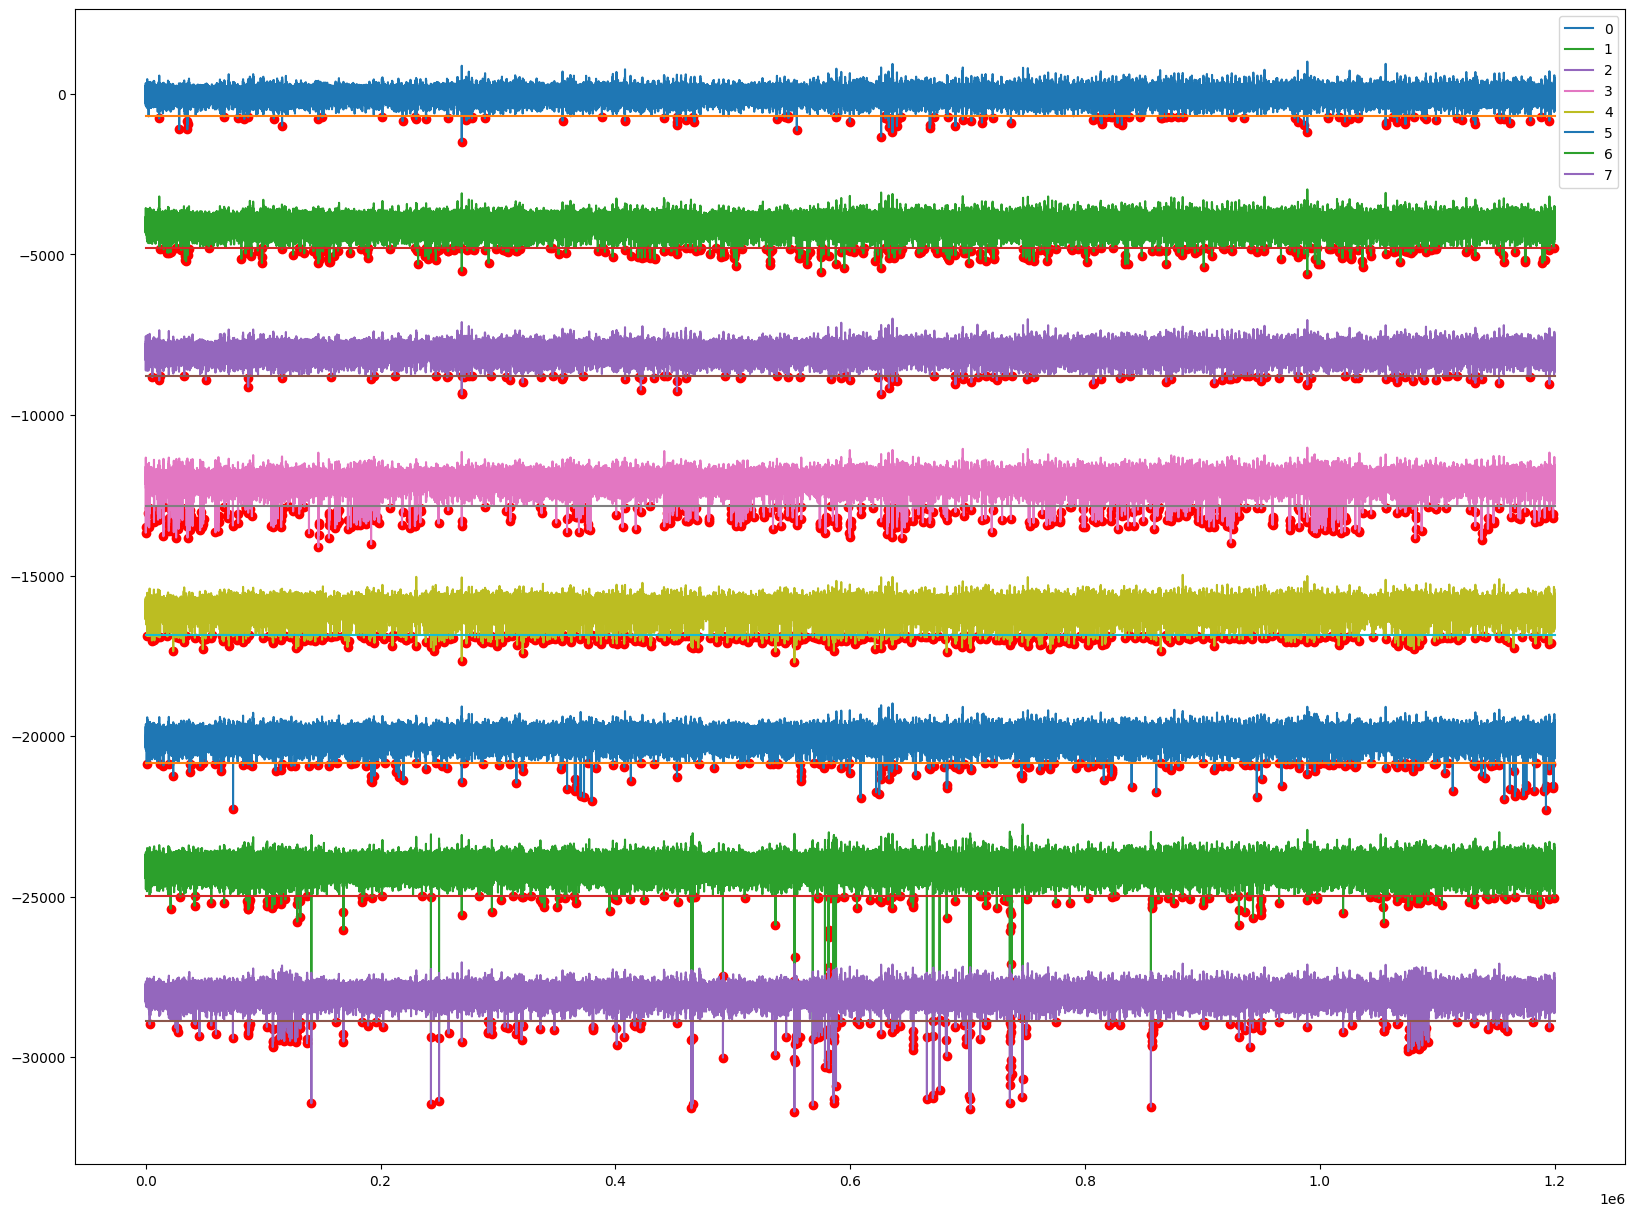

In [5]:
%%time
# plot the data and run all the analysis performed so far
z=6
offset=4000
lowcut=300
spikeDetection.plot_recording_data(dat,startSample=0,endSample=20000,offset=offset)
y = spikeDetection.filter_raw_data(dat,lowcut=lowcut, fs=fs)  # filter the data
spikeTimesList, thresholds = spikeDetection.spike_detection(y,z=z) # detect the spikes
spikeDetection.plot_spike_detection(y,spikeTimesList,thresholds,offset)

To make our task easier, we will work on the spikes detected on channel 3, 5 and 7. 

In [6]:
spikeTimesList[0]

array([  11543,   28542,   35421,   35520,   35648,   66923,   78243,
         83987,   87281,  109113,  116150,  147024,  150527,  201609,
        218804,  229310,  230439,  238677,  257653,  269167,  273009,
        273208,  275186,  277819,  277821,  288883,  354997,  388515,
        408202,  408204,  441488,  452375,  452378,  452440,  459943,
        466216,  467377,  537289,  544121,  547360,  547363,  554516,
        588199,  599657,  626299,  629634,  630038,  632571,  632573,
        632623,  632925,  635997,  636001,  639801,  639915,  643477,
        667723,  668136,  671632,  683006,  689614,  695856,  703140,
        712153,  713426,  721528,  736829,  806985,  809429,  813239,
        814021,  818242,  822308,  823456,  827693,  829459,  831344,
        831425,  837607,  846634,  864374,  865925,  869051,  869054,
        873480,  879542,  883184,  924772,  935562,  978477,  981285,
        986418,  989245, 1006552, 1006554, 1015866, 1021368, 1025319,
       1032151, 1032

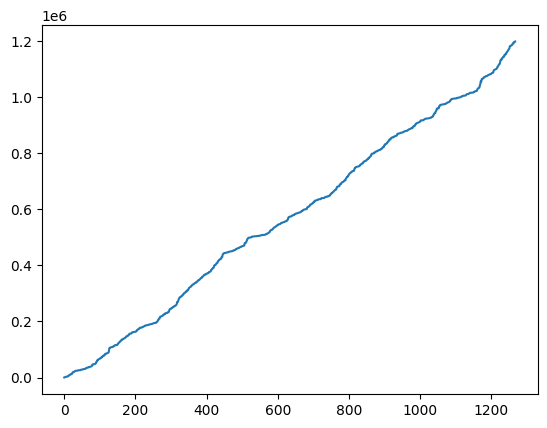

In [7]:
a = np.concatenate([spikeTimesList[3],spikeTimesList[4]])

a.sort()
plt.plot(a)

Number of spikes:  1134


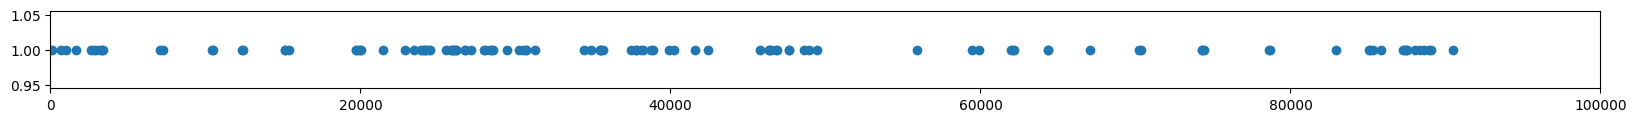

In [8]:
spikeTimes = np.concatenate([spikeTimesList[3],spikeTimesList[5],spikeTimesList[7]])
spikeTimes.sort() # sort the spike times
spikeTimes = np.unique(spikeTimes) # remove duplicates
print("Number of spikes: ", spikeTimes.shape[0])

# plot our spike times
plt.figure(figsize=(20,1))
plt.scatter(spikeTimes,np.ones_like(spikeTimes))
plt.xlim(0,100000)
plt.show()

In [9]:
spikeTimes

array([     98,     669,     973, ..., 1198590, 1198652, 1198842])

We have a list of spike times. 

In this step, we want to extract the waveforms for these spikes from the filtered signal and store them in a new NumPy array.

<div>
<img src="../images/spike_extraction.png" width="800"/>
</div>

We must decide how many samples we collect per spike to do this. 40 could be a reasonable choice. This is 1 ms before and 1 ms after the spike negative peak. 

* Axis 0: 8 channels
* Axis 1: 40 samples
* Axis 2: many spikes

Each spike will be represented as a 2D array.

We create a 3D array to have a stack of 2D arrays.

Let's create our 3D array to store our spike waveforms.

In [10]:
print("dat shape:",dat.shape)
print("spikeTimes shape:", spikeTimes.shape)

dat shape: (8, 1200000)
spikeTimes shape: (1134,)


In [11]:
samplesPerSpike=40
waveforms=np.empty((dat.shape[0],samplesPerSpike,spikeTimes.shape[0]))
print("Shape of the waveforms array:",waveforms.shape)

Shape of the waveforms array: (8, 40, 1134)


### Exercise

Get a 2D array with the data from the first spike. Then, plot it and try to find out if you have the correct data.


In [12]:
st = spikeTimes[0]
st
start=int(st-samplesPerSpike/2)
end=int(st+samplesPerSpike/2)
start,end


(78, 118)

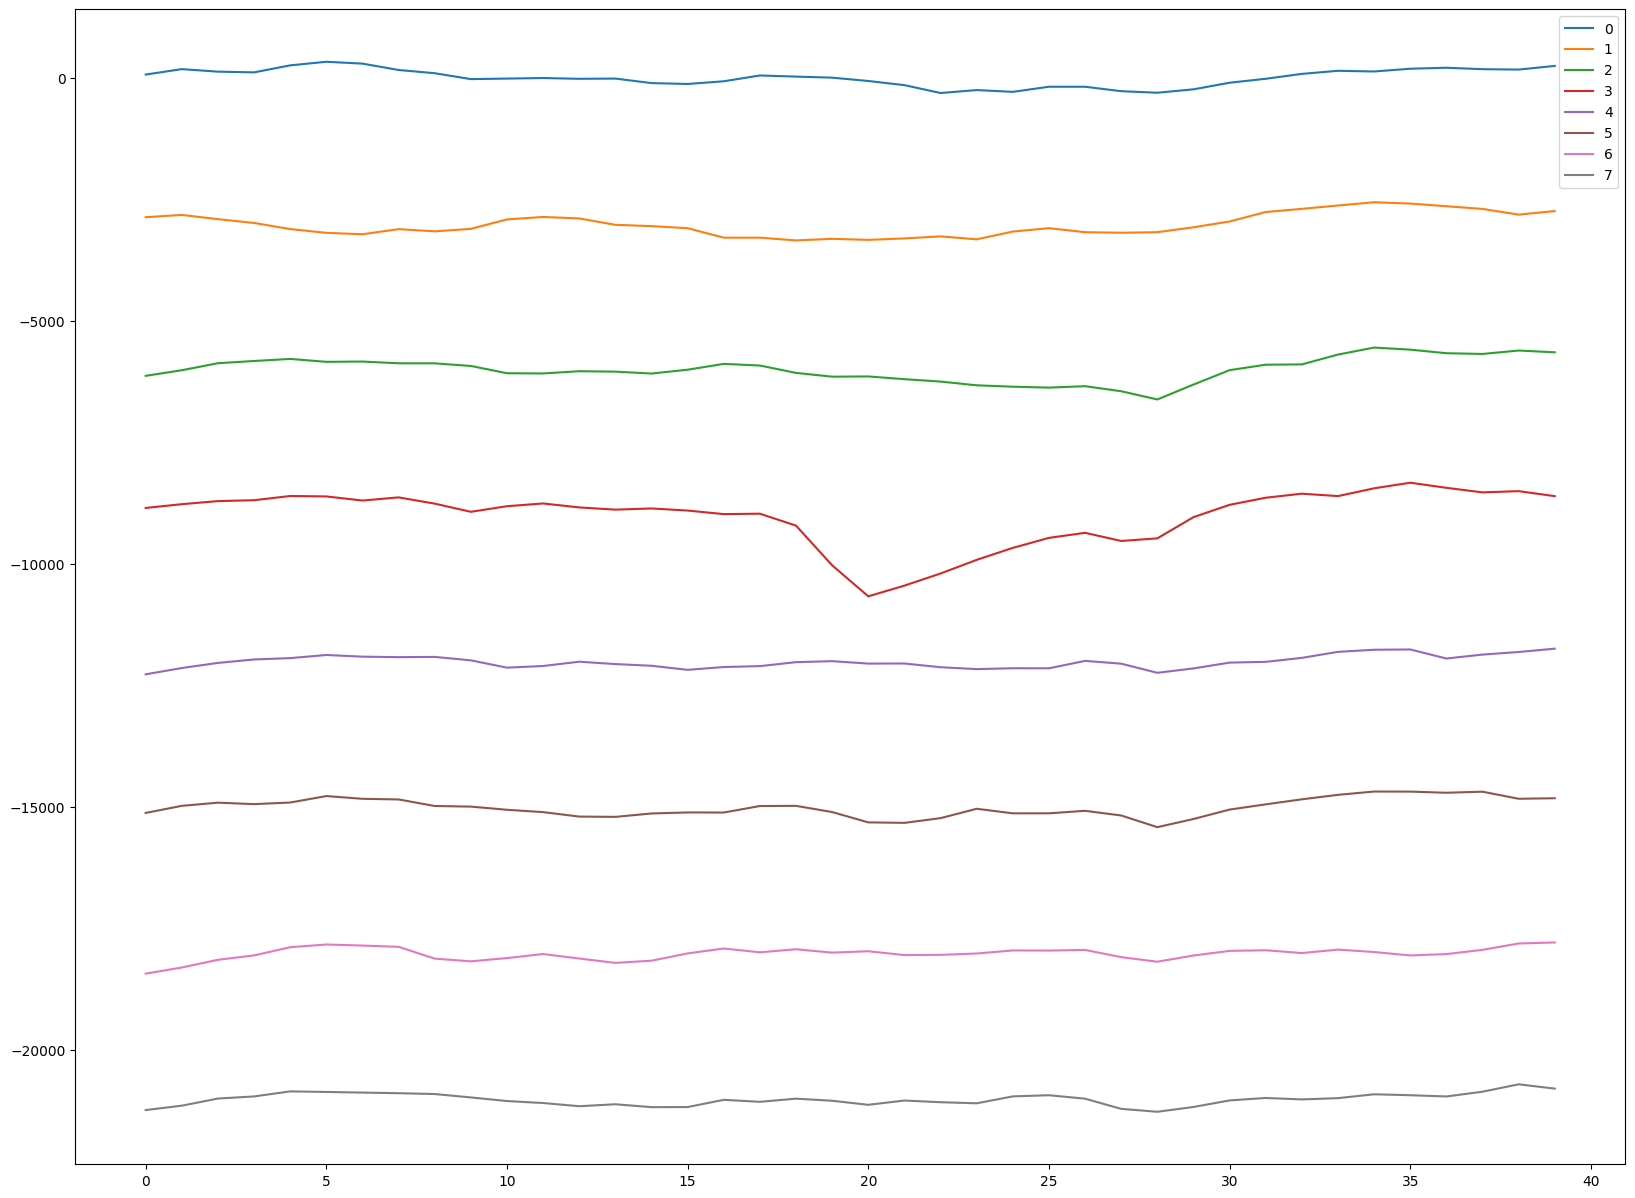

In [13]:
waveform = y[:,start:end]

spikeDetection.plot_recording_data(waveform,startSample=0,endSample=20000,offset=3000)

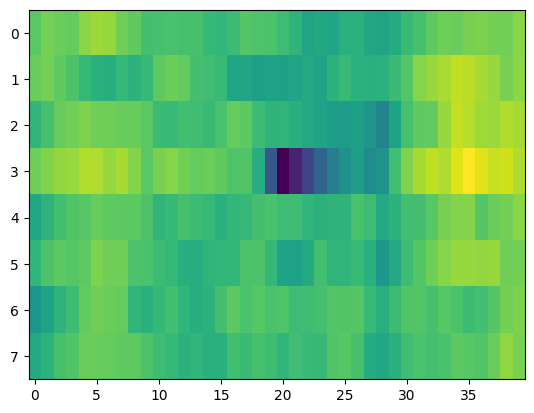

In [14]:
plt.imshow(waveform,aspect='auto')

In [15]:
waveforms.shape, waveform.shape

((8, 40, 1134), (8, 40))

In [16]:
waveforms[:,:,0] = waveform

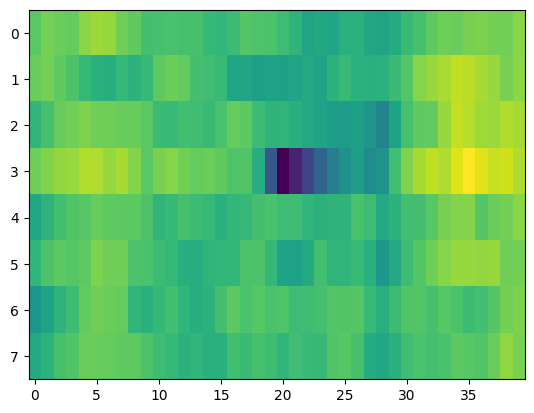

In [17]:
plt.imshow(waveforms[:,:,0],aspect='auto')

Create a loop to loop over the spike time and and put the waveforms in the 3D array. 

In [18]:
for i in range(waveforms.shape[2]):
    st = spikeTimes[i]
    start_index=int(st-samplesPerSpike/2)
    end_index=int(st+samplesPerSpike/2)
    waveform = y[:,start_index:end_index]
    waveforms[:,:,i] = waveform

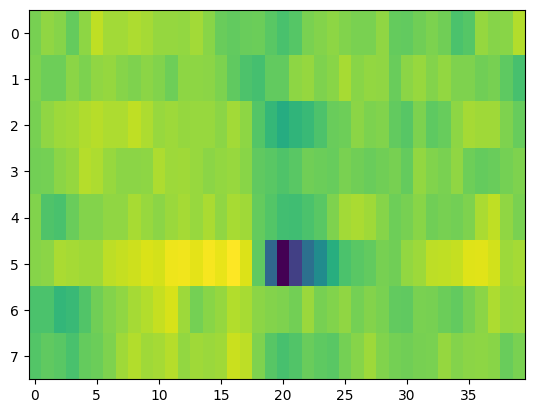

In [19]:
plt.imshow(waveforms[:,:,-1],aspect='auto')

As always, plot your results to make sure it looks like you expect.

## Visualize your results

As always, **visualize your results**. As 3D plots are hard to visualize, we will plot a series of 2D plots.

Here are some guidlines to visualize the content of NumPy arrays of different dimensions. 

#### 1D 
* plt.plot(x)
* plt.hist(x)

#### 2D
* plt.plot(x[i,:]
* plt.hist(x[i,:]))
* plt.imshow()

#### 3D
* plt.plot(x[i,j,:])
* plt.imshow(x[i,:,:])

In our case, we will use `plt.imshow()` several times, once per spike.

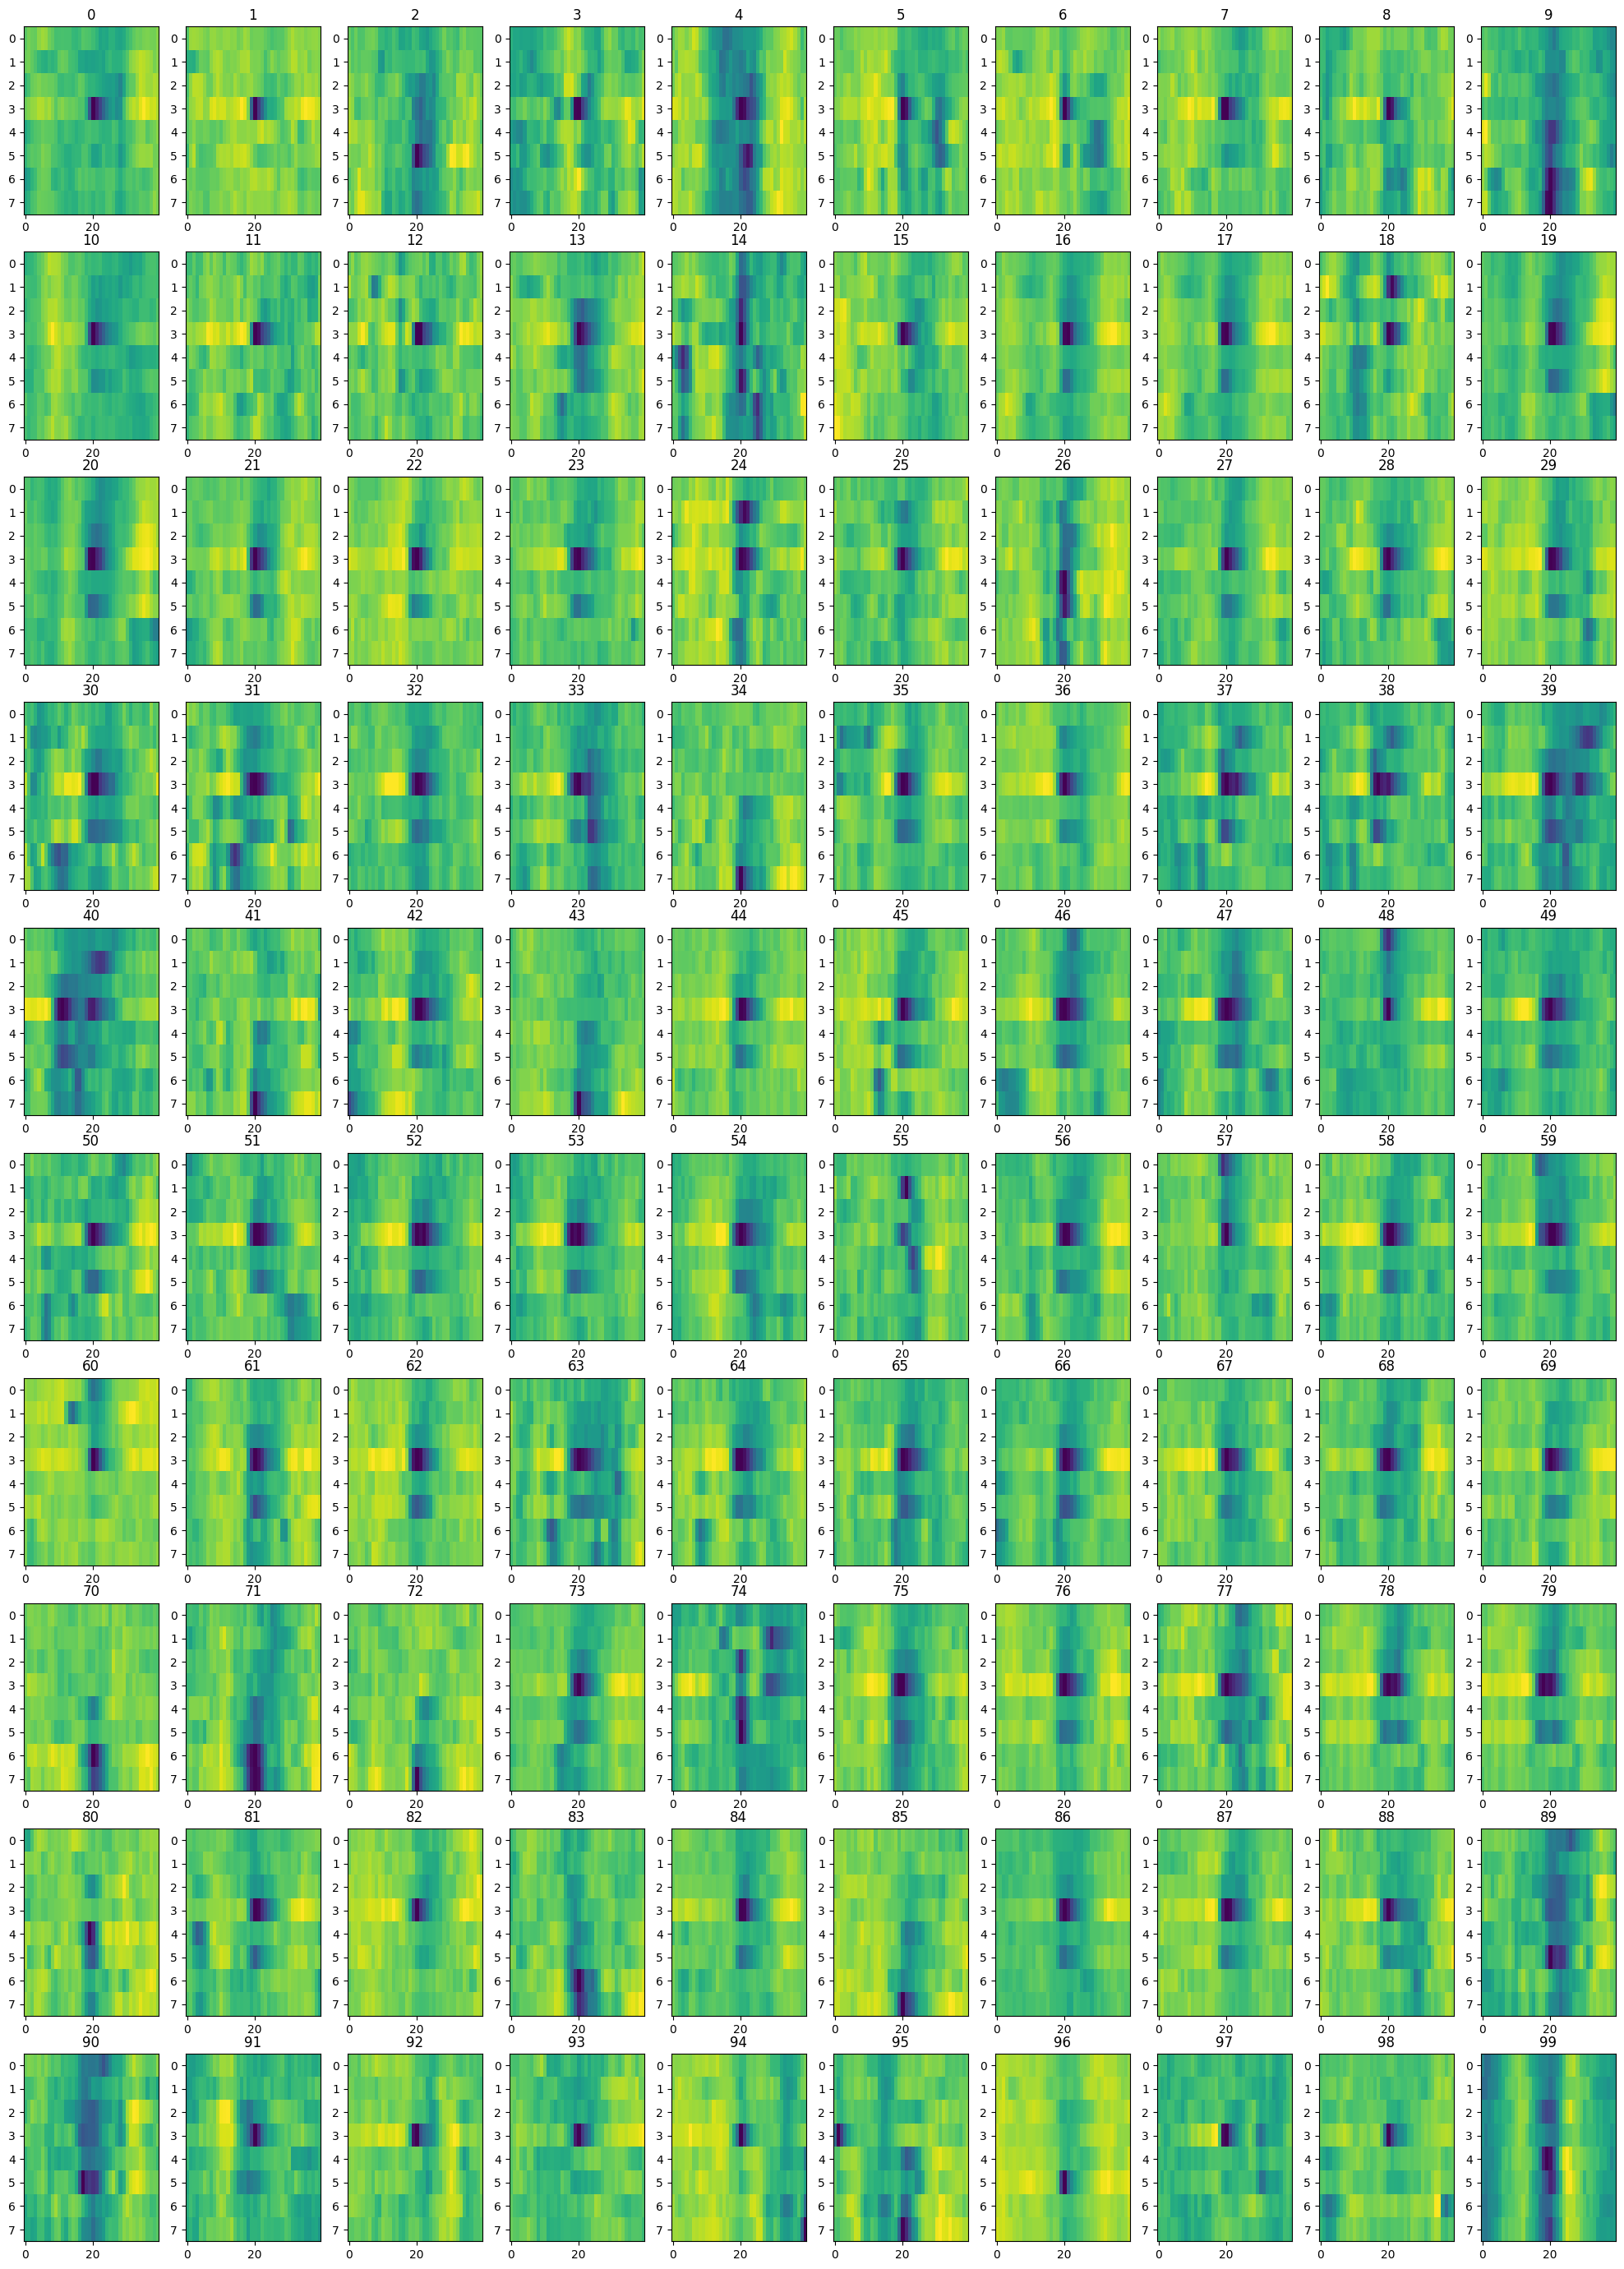

In [20]:
nrow=10
ncol=10
fig, ax = plt.subplots(nrow,ncol,figsize=(25,35))
for i in range(100):
    
    ax[int(i/ncol),i%ncol].imshow(waveforms[:,:,i],aspect="auto",interpolation="none")
    ax[int(i/ncol),i%ncol].set_title(i)

## Discussion

* What do you see in this figure? What is on the x-axis and y-axis of each image?
* Do you notice some patterns in the data?
* Are there spikes that are clearly different from the other ones?
* Do you think there are groups of spikes with similar waveforms that might originate from the same neuron?

***
# Dimensionality reduction

Our end goal is to cluster the spikes in groups with very similar spike waveforms (putative neurons). This can be done with different clustering algorithms. In the context of clustering, every data point of a 2D waveform is a feature of the waveform.

One problem is that we have 320 (8 channels * 40 samples) data points per spike. If we had more than 100,000 spikes, as commonly seen in the lab, the clustering algorithms would be very slow.

Our aim with dimensionality reduction is to reduce the number of features for each spike without losing too much information.

The idea is to summarize our data with a few numbers instead of having the whole waveform. 

The traditional way to do dimensionality reduction is with **principal component analysis**.

For our waveforms with 320 data points, we can get a few important features.

<div>
<img src="../images/waveformPCA.png" width="300"/>
</div>



## Reasons for using dimensionality reduction:

1. Allows you to visualize the data by reducing it to 2 or 3 important features.
2. Calculations using few features are much faster than computations using all features.


There are now many different algorithms for dimensionality reduction (e.g., autoencoder, t-SNE, UMAP, etc.).

Dimensionality reduction is often used in Neuroscience when working with data with many features (e.g., gene sequencing).

## Principal component analysis (PCA)

Principal component analysis is the process of computing the principal components and using them to change the basis of the data.

We will use the first few components that explain most of the variance in the data, and ignore the components that explain little variance. 

Each component is a linear combination of the features and a set of coefficients. The first component is the vector with the most variance in the data.

* [wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis)
* [PCA with scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

We will use a class from the [Scikit-Learn](https://scikit-learn.org/stable/index.html#) package to do PCA. Scikit-Learn is a package to apply **machine learning** in Python. 

### Simple example of PCA with simulated data

We will use simulated data to get an idea of what the PCA transformation does to our data.

We will go back to our spike waveforms after this simple example.

Let's generate a very simple data set with 2 features (2D) per data point.

Shape of X: (50, 2)


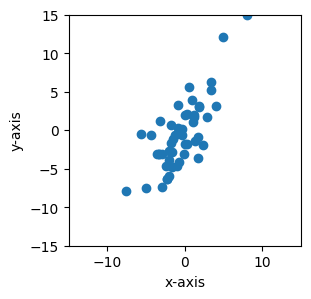

In [21]:
n=50 # 50 points 
xx = np.random.normal(loc=0,scale=3,size=n) # pick some random numbers from a normal distribution for our first dimension
yy = xx*1.2+np.random.normal(loc=0,scale=3,size=n) # our second dimension is a function of the first one, plus some random noise.
X = np.vstack([xx,yy]).T
print("Shape of X:", X.shape)
plt.figure(figsize=(3,3))
plt.scatter(X[:,0],X[:,1])
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.show()

In [23]:
X

array([[-2.41404319, -4.58822779],
       [ 0.4943253 ,  5.58702115],
       [ 1.83469208,  3.0713176 ],
       [-1.63360849, -2.77245257],
       [ 0.8879695 ,  3.9683997 ],
       [-0.31785899, -0.6198162 ],
       [-1.97627169, -5.94024739],
       [-0.08653494, -3.05921794],
       [ 3.36119765,  6.29905981],
       [-2.33338461, -6.29109337],
       [ 1.21473211,  2.02776439],
       [-0.93906655,  0.23023507],
       [ 2.88830454,  1.75276623],
       [-1.30481355, -0.63382482],
       [ 0.23019266, -1.85081579],
       [-1.98007868, -2.68048582],
       [-7.55904912, -7.87309338],
       [ 1.7029671 , -3.61325772],
       [ 0.06973322, -1.83899607],
       [ 0.26937158,  2.07428823],
       [-0.75714065, -4.11684166],
       [-3.3106525 , -3.0415444 ],
       [-1.75933238,  0.66446929],
       [ 2.38144757, -1.96171607],
       [-2.91578677, -3.08071551],
       [ 1.21140575,  1.66771405],
       [ 8.07748517, 14.94377446],
       [-1.81585326, -1.66141265],
       [-2.93158449,

In [25]:
from sklearn.decomposition import PCA

In [26]:
pca = PCA() 

In [27]:
pca.fit(X)

PCA()

In [29]:
print("components:")
print(pca.components_)
print("explanied variance:")
print(pca.explained_variance_)
print("explained variance ratio")
print(pca.explained_variance_ratio_)
print("mean")
print(pca.mean_)

components:
[[ 0.47914269  0.87773702]
 [ 0.87773702 -0.47914269]]
explanied variance:
[25.97478511  2.66213714]
explained variance ratio
[0.90703829 0.09296171]
mean
[-0.5143654  -0.55040641]


Don't worry about the code in the cell below. We just want to display the vectors obtained by fitting the data.

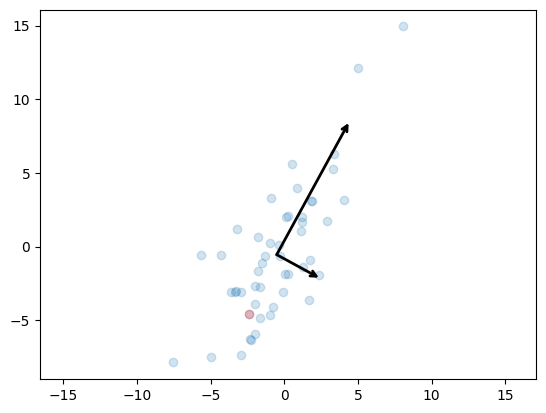

In [34]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
    
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 2 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');
plt.scatter(X[0, 0], X[0, 1], alpha=0.2, c='r')

Use the `PCA.fit_transform()` method to go from 2 features to 1.

In [35]:
Xt = pca.fit_transform(X)
print("shape of X:", X.shape, "shape of Xt:", Xt.shape)

shape of X: (50, 2) shape of Xt: (50, 2)


In [37]:
print("Original first data point: ", X[0])
print("Transformed first data point: ", Xt[0])

Original first data point:  [-2.41404319 -4.58822779]
Transformed first data point:  [-4.45436204  0.26727507]


Let's plot the transformed data. 

(-10.0, 10.0)

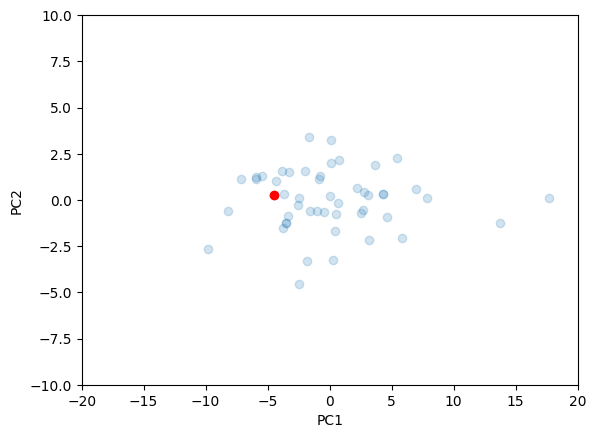

In [41]:
plt.scatter(Xt[:,0],Xt[:,1],alpha=0.2)
plt.scatter(Xt[0,0],Xt[0,1],c='r')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlim(-20,20)
plt.ylim(-10,10)


What happened to our original data? Can you identify the transformation? 


The main idea is that the axes with the most variance are now aligned with the x and y axes.

The first axis in the transform data (or component) has the most variability, the second axis, the second most variability, etc.

If we want to perform **dimensionality reduction**, we can use the first component (x-axis) to represent our data.

In [42]:
print("Proportion of the variance explained by the first component: {:.4f}".format(pca.explained_variance_ratio_[0]))

Proportion of the variance explained by the first component: 0.9070


This means that the first dimension of the transformed data explained approximately 90% of the variance in the original data. We went from 2 to 1 dimensions, but we can still explain most of the variance in the original data.

The principal component analysis performs linear transformation. This is a reversible step.

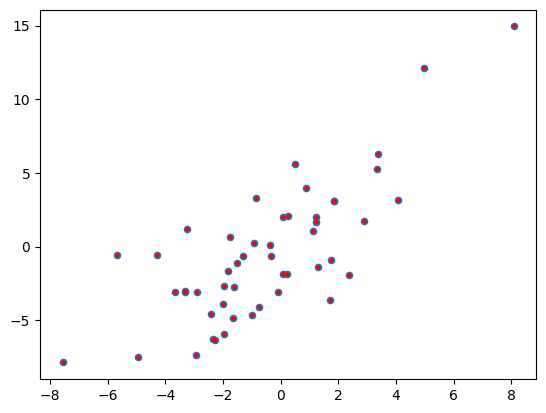

In [43]:
Xori = pca.inverse_transform(Xt)
plt.scatter(Xori[:,0],Xori[:,1],alpha=1,s=20)
plt.scatter(X[:,0],X[:,1],alpha=1,s=5,color="red",zorder=1)

If we don't use all the component, we can't return to the exact original data.

In [44]:
pca = PCA(n_components=1)
Xt = pca.fit_transform(X)
print("shape of X:", X.shape, "shape of Xt:", Xt.shape)

shape of X: (50, 2) shape of Xt: (50, 1)


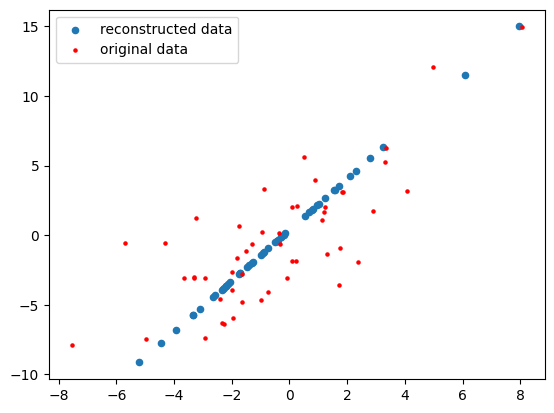

In [45]:
Xinv = pca.inverse_transform(Xt)
plt.scatter(Xinv[:,0],Xinv[:,1],alpha=1,s=20, label="reconstructed data")
plt.scatter(X[:,0],X[:,1],alpha=1,s=5,color="red",zorder=1, label="original data")
plt.legend()

## Apply PCA to our spike waveforms

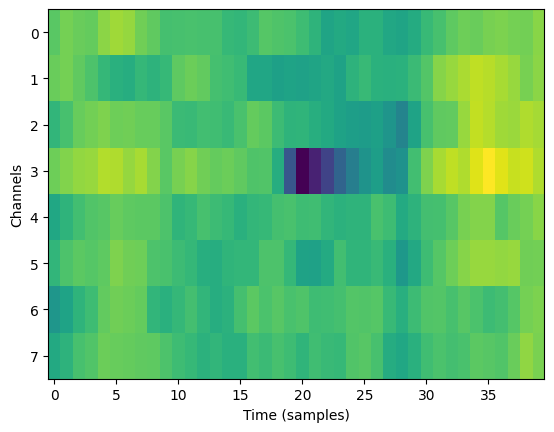

One waveform shape: (8, 40)
Features per spike: 320


In [46]:
plt.imshow(waveforms[:,:,0],aspect="auto",interpolation="none")
plt.xlabel("Time (samples)")
plt.ylabel("Channels")
plt.show()
oneSpike= waveforms[:,:,0]
print("One waveform shape:",oneSpike.shape)
print("Features per spike:",oneSpike.shape[0]*oneSpike.shape[1])

We have too many features: 320 (8 channels * 40 samples) data points per spikes. If we had more than 100,000 spikes as commonly seen in the lab, the clustering algorithms would be very slow.

### Aim : summarize the data as accurately as possible with fewer features

Each spike is a 320-feature observation. We have 320 dimensions. 

The [PCA.fit() function](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit) of Scikit-Learn takes a 2D NumPy array with one observation per row, and one feature per colomn. 

We therefore need to get a 2D array (spikes,features) from our 3D array of spikes (spikes,channel,time).

In machine learning, we often need to format our input data so that we have `one observation per row` and `one feature per column`.


### Transform our waveform array so that it is suitable for PCA

<div>
<img src="../images/spike_features_array_transformation.png" width="1000"/>
</div>





### Most machine learning algorithms work with 2D NumPy arrays [observations,features].

In [47]:
print("waveforms shape:",waveforms.shape)
wf_fea = waveforms.transpose(2,0,1) # reorder to spike,channel,time
wf_fea.shape

waveforms shape: (8, 40, 1134)


(1134, 8, 40)

In [48]:
wf_fea = wf_fea.reshape(wf_fea.shape[0],-1)
print("wf_fea.shape:",wf_fea.shape)

wf_fea.shape: (1134, 320)


Let's plot the data to make sure what we did makes sense.

Text(0, 0.5, 'Spikes')

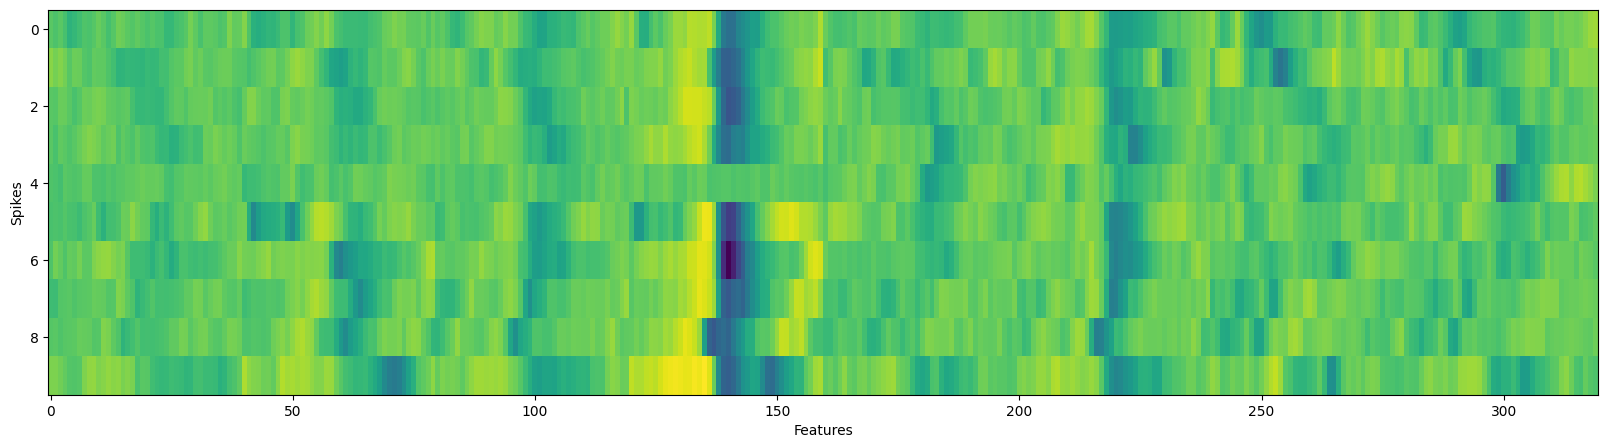

In [49]:
plt.figure(figsize=(20,5))
plt.imshow(wf_fea[30:40,],aspect="auto",interpolation=None)
plt.xlabel("Features")
plt.ylabel("Spikes")

We can write a function to transform our 3D waveforms array to 2D features array.

In [50]:
def waveform2feature(wf):
    """
    turns a 3D array [channels,samples,spikes] into a 2D array [spikes,features]
    """
    wf = wf.transpose(2,0,1) # 
    wf = wf.reshape(wf.shape[0],-1)
    return wf

In [51]:
wf_fea = waveform2feature(waveforms)
wf_fea.shape

(1134, 320)

You can also go from wf_fea to the original waveforms using the `np.reshape()` and and `np.transopose()`

In [52]:
def feature2waveform(X,nChannels=8,nSamples=40):
    """
    turns a 2D array [spike,features] into a 3D array [channels,samples,spikes]
    """
    res = X.reshape((X.shape[0],nChannels,nSamples)) # spikes, channels,samples
    res = res.transpose(1,2,0) # channels,samples,spikes
    return res

In [53]:
wf_fea.shape

(1134, 320)

In [54]:
res = feature2waveform(wf_fea)

Text(0, 0.5, 'Channels')

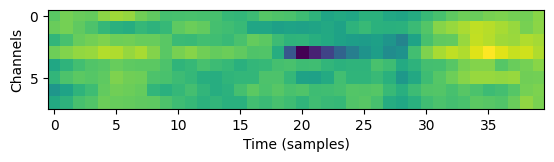

In [55]:
plt.imshow(res[:,:,0])
plt.xlabel("Time (samples)")
plt.ylabel("Channels")

Let's now work with the waveform 320 features. 

In [56]:
waveforms.shape,wf_fea.shape

((8, 40, 1134), (1134, 320))

With the data in the correct format, we can now perform the principal component analysis.

In [57]:
X = wf_fea
pca = PCA(n_components=20) 
pca.fit(X)

PCA(n_components=20)

[0.2799666  0.18287984 0.09765517 0.04867563 0.04637084 0.03787935
 0.02369343 0.02291512 0.0166045  0.01504372 0.01271984 0.01062211
 0.01020937 0.00929354 0.00858053 0.00700607 0.00688681 0.00651032
 0.00597012 0.00518458]
Total explained variance:  0.8546674896420766


Text(0, 0.5, 'Explained variance')

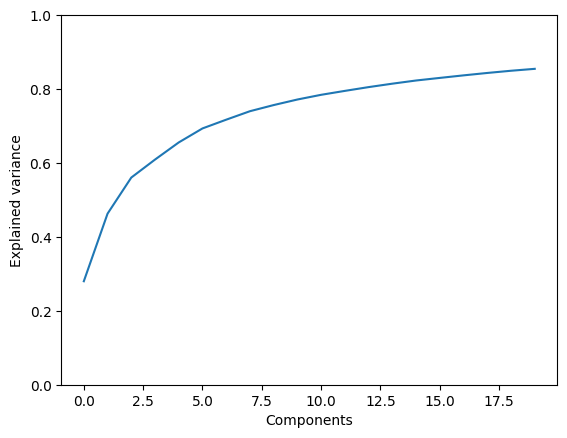

In [58]:
print(pca.explained_variance_ratio_)
print("Total explained variance: ", np.sum(pca.explained_variance_ratio_))
#
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(0,1)
plt.xlabel("Components")
plt.ylabel("Explained variance")

In [59]:
Xt = pca.transform(X)
print("X dimensions:",X.shape)
print("Xt dimensions:",Xt.shape)

X dimensions: (1134, 320)
Xt dimensions: (1134, 20)


We went from 320 to 20 features per spikes. 

We can print the first 2 PC of the spikes.

Text(0, 0.5, 'Spikes')

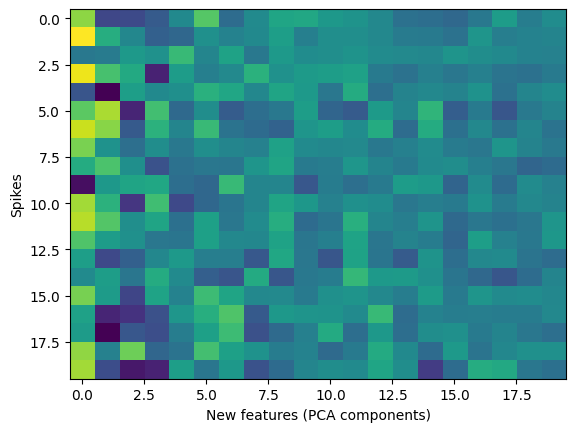

In [61]:
plt.imshow(Xt[0:20],aspect="auto",interpolation=None)
plt.xlabel("New features (PCA components)")
plt.ylabel("Spikes")

After dimensionality reduction, we have 20 features per spikes instead of 320. We have lost 15% of the variability in the data.

We can have a look at the components that were extracted. This is how much each feature of the original waveform is weighted. 

In [43]:
pca.components_.shape

(20, 320)

We can plot the coefficients for the first component.

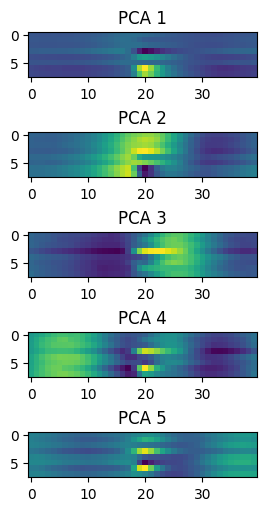

In [64]:
nComponents=5
size=5
fig,ax = plt.subplots(nComponents,1,figsize=(size*nComponents,size), constrained_layout=True)
for comp in range(nComponents):
    ax[comp].imshow(pca.components_[comp].reshape(8,-1)) # reshape to go from 1x320 to 8x40
    ax[comp].set_title("PCA {}".format(comp+1))

Each component represents a linear combination of the original features. 

They reflect the correlations between the input features.

In a component, each feature is given a weight that can be positive or negative.

### Plot our spikes in PCA space

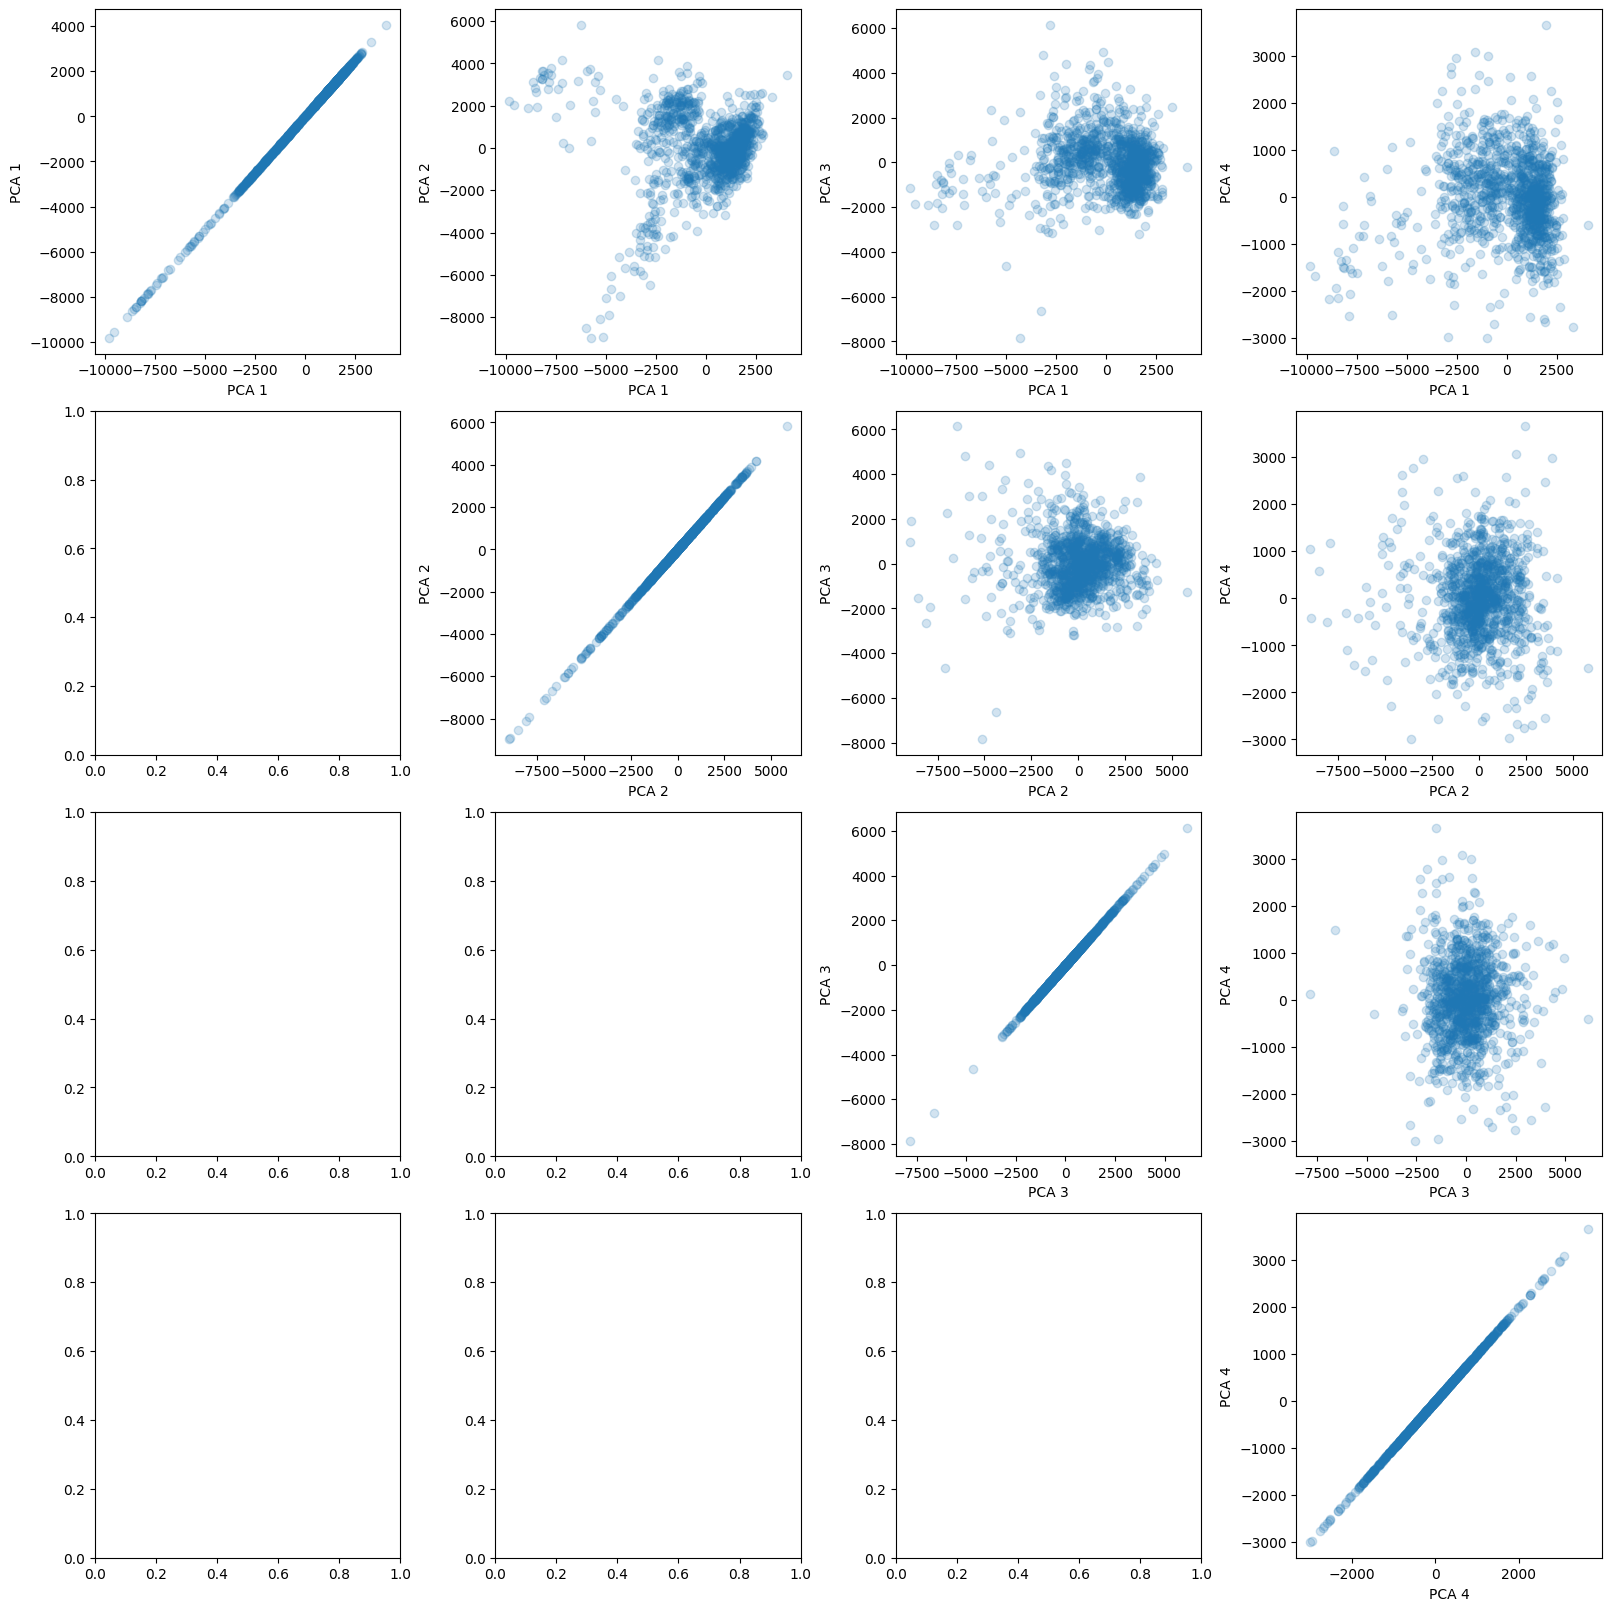

In [69]:
fig,ax = plt.subplots(4,4,figsize=(16,16), constrained_layout=True)
for i in range(4):
    for j in range(4):
        if i<=j:
            ax[i,j].scatter(Xt[:,i],Xt[:,j],alpha=0.2)
            ax[i,j].set_xlabel("PCA {}".format(i+1))
            ax[i,j].set_ylabel("PCA {}".format(j+1))
        
plt.show()

### Discussion

* Do you notice any patterns in the data?
* Do you think we recorded the activity of more than one neurons?

### Exercise

Get the waveform back from the PCA components

***
## Clustering spike waveforms

We would now like to group our spikes according to how similar they are.

This is a [clustering](https://scikit-learn.org/stable/modules/clustering.html#clustering) problem. scikit-learn has many clustering algorithms ready for you to use.

The documentation on the Scikit-Learn website can help you choose an approriate clustering algorithm. 

### k-means clustering

The k-means algorithm is one of the most commonly used clustering techniques. 

With k-means clustering, you need to know how many clusters you expect.

After initialization, K-means consists of looping between the two other steps. 

* Assigns each sample to its nearest centroid. 
* Creates new centroids by taking the mean value of all of the samples assigned to each previous centroid. 

You can visualize the procedure in videos: https://www.youtube.com/watch?v=nXY6PxAaOk0

In [47]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto")
kmeans.fit(Xt)

KMeans(n_clusters=4, n_init='auto', random_state=0)

You can get the cluster ID of each spike from `kmeans.labels_`.

In [48]:
print("Xt.shape:",Xt.shape)
print("kmeans.labels_.shape",kmeans.labels_.shape)
kmeans.labels_

Xt.shape: (1134, 20)
kmeans.labels_.shape (1134,)


array([1, 1, 3, ..., 1, 3, 3], dtype=int32)

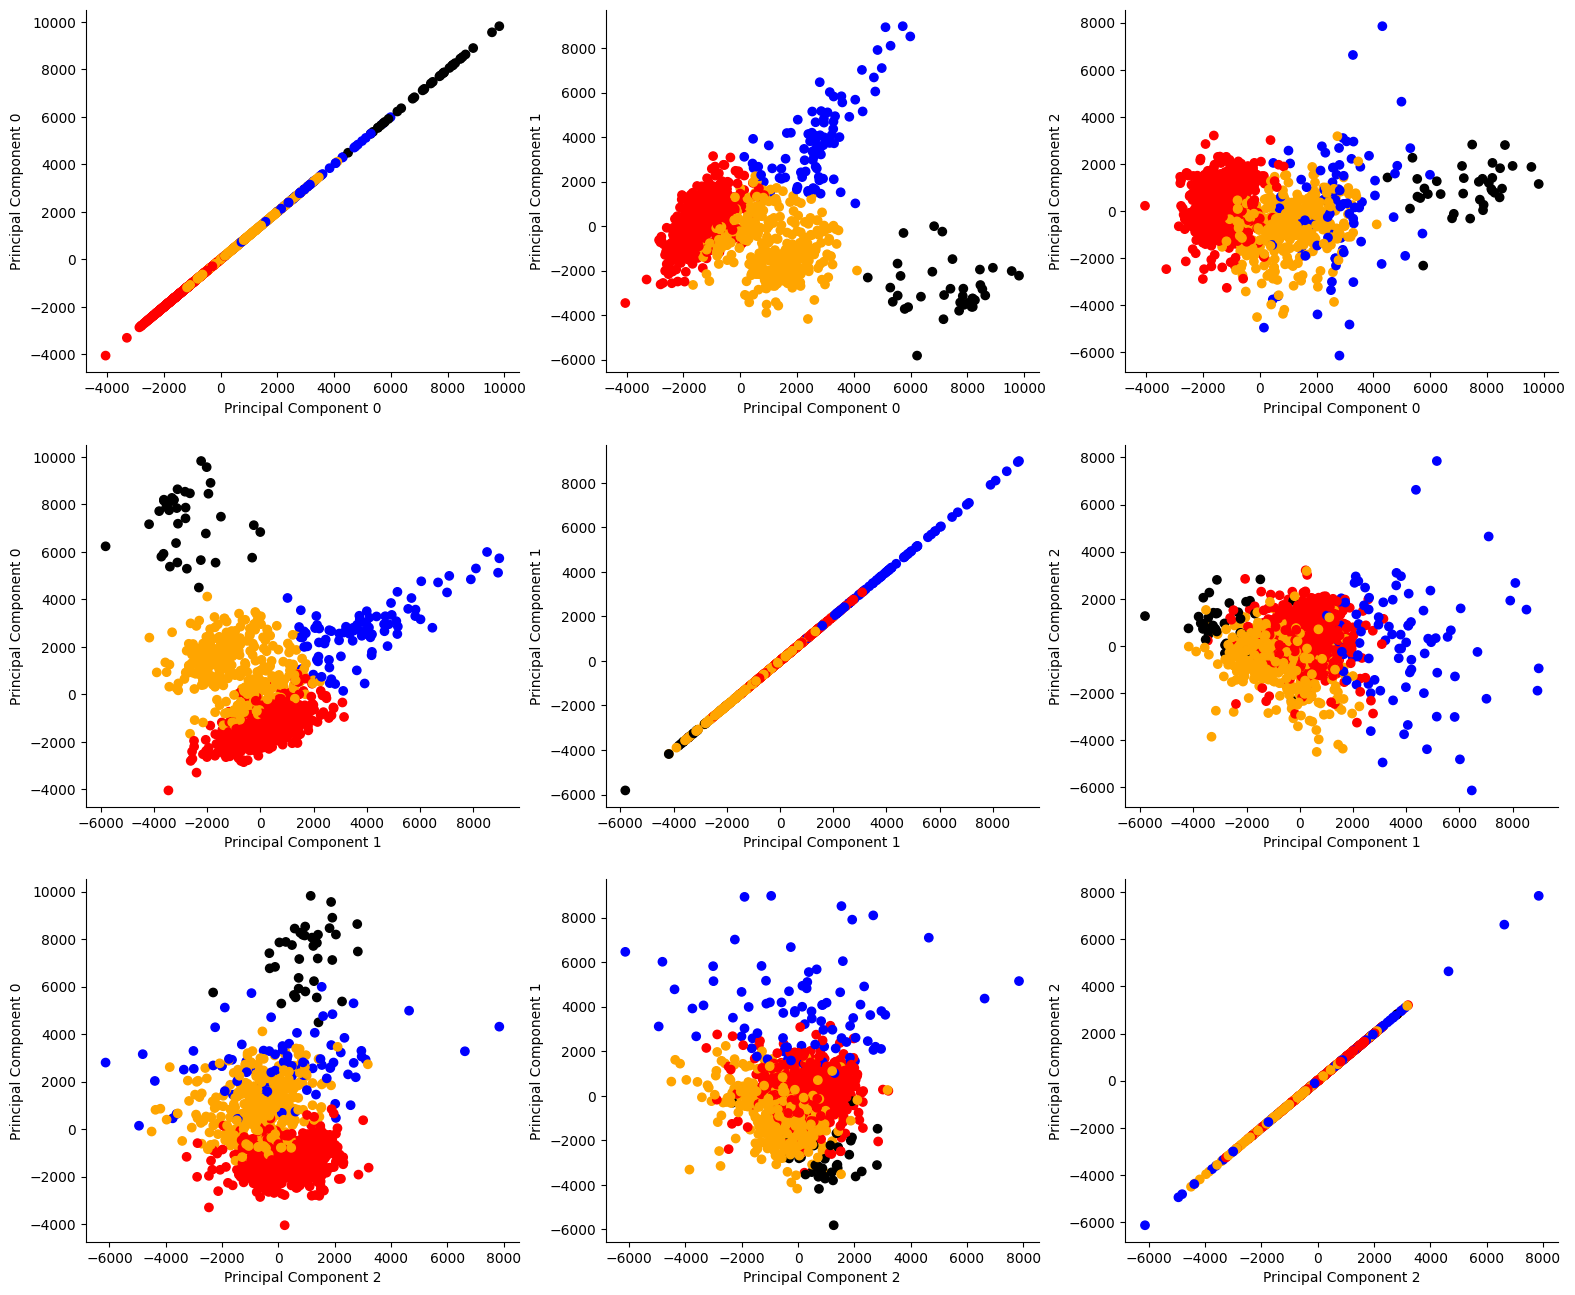

In [49]:
myColorsDict={0:"blue",1:"red",2:"black",3:"orange",4:"purple",5:"green",6:"gray"} # list of color to show different clusters in different colors
labelColor = [myColorsDict[i] for i in kmeans.labels_]

fig,ax = plt.subplots(3,3,figsize=(19,16))
for i in range(3):
    for j in range(3):
        ax[i,j].scatter(Xt[:,i],Xt[:,j],c=labelColor)
        ax[i,j].set_xlabel("Principal Component {}".format(i))
        ax[i,j].set_ylabel("Principal Component {}".format(j))
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
fn="../images/pca.png"
plt.savefig(fn)
plt.show()

## Exercises: 

Calculate the mean waveform of each spikes of cluster 0 and plot the results as an 8 x 40 array.

Tips: 

* You can use the `kmeans.labels_` array, your `waveforms` array, and the np.mean() method.
* You might want to perform [boolean indexing of a NumPy array](https://numpy.org/doc/stable/user/basics.indexing.html#boolean-array-indexing) to subset the `waveforms` array to the spikes of a single cluster.

Plot the mean waveform of the 4 clusters.

Change the values of `n_clusters` when running the KMeans.fit() function and plot the results. What is the effect?

It is also possible to do calculations in PCA space (20 features) and then transform the results back into our original space (320 features). 

Calculate the mean waveform of cluster 0. But this time, calculate the mean in the PCA space and apply the inverse transform of the PCA to retrieve the mean waveform.

What are the potential advantages and problems with this approach?

# Summary

After this week, you should 

* Be able to write functions in Python.
* Have used Scikit-Learn to perform PCA and K-means clustering.
* Understand how to use Principal Component Analysis to reduce the dimensionality of a dataset.
* Have applied a K-Means clustering to a dataset and visualize the resutls.

